In [1]:
import pandas as pd
import time
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_pickle(r'D:\JupyterNotebook\DataProcess\preprocess_SWsastrawi_stemming.pkl')
dfNo = pd.read_pickle(r'D:\JupyterNotebook\DataProcess\preprocess_SWsastrawi_nostemming.pkl')

In [3]:
def split(strt,fnsh,df):
    X_test = df['text'].iloc[strt:fnsh]
    y_test = df['label'].iloc[strt:fnsh].astype('int')
    df.drop(df.index[strt:fnsh])
    X_train = df['text']
    y_train = df['label'].astype('int')    
    return X_train, X_test, y_train, y_test

In [4]:
def select_features(train_X, train_y, test_X,k):
    selector = SelectKBest(chi2, k=k)
    selector.fit(train_X, train_y)
    train_X = selector.transform(train_X)
    test_X = selector.transform(test_X)
    return train_X, test_X

In [5]:
def classifier(df,distance_name,k_neighbor):
    print("Nama distance=",distance_name)
    print("Jumlah K tetangga=",k_neighbor)
    spl = [0,108,216,324,432,540,648,756,864,972,1080]
    tempspl = []
    i = 0
    akurasimax=0
    while (i<len(spl)-1):
        if len(spl)-2 != len(tempspl):
            X_train, X_test, y_train, y_test = split(spl[i],spl[i+2],df)
            tempspl.append(spl[i])
    #   ketika array[i+2] == null (looping terakhir)
        elif (len(spl)-len(tempspl)) == 2:
    #       split last and first
            X_test1 = df['text'].iloc[spl[i]:spl[i+1]]
            y_test1 = df['label'].iloc[spl[i]:spl[i+1]].astype('int')
            X_test2 = df['text'].iloc[tempspl[0]:tempspl[1]]
            y_test2 = df['label'].iloc[tempspl[0]:tempspl[1]].astype('int')
    #       concat last and first
            X_test = pd.concat([X_test1, X_test2], axis=0)
            y_test = pd.concat([y_test1, y_test2], axis=0)
    #       split except last and first
            X_train = df['text'].iloc[tempspl[1]:tempspl[len(tempspl)-1]]
            y_train = df['label'].iloc[tempspl[1]:tempspl[len(tempspl)-1]].astype('int')
        
        vectorizer = TfidfVectorizer(min_df=3, dtype=np.double, norm='l2', sublinear_tf=True)
#         vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)

        modelknn = KNeighborsClassifier(n_neighbors=k_neighbor, weights='uniform', metric=distance_name)
        modelknn.fit(X_train,y_train)
        y_pred = modelknn.predict(X_test)
#         print(classification_report(y_test,y_pred))
        result = modelknn.score(X_test, y_test)
        print("Fold ke-",i+1,"=",result)
        if (result >= akurasimax):
            akurasimax = result
            foldke = i+1
        i+=1
    print("Akurasi terbaik adalah",akurasimax,"pada fold ke-",foldke)
    print("------------------------------------")
    return akurasimax

In [ ]:
%%time
start_time = time.time()
dfcount = [df,dfNo]
distancecount = ['euclidean','manhattan','minkowski']
kcount = [1,3,5,7,9,11,13,15]
for x in range(2):
    arrd1 = []
    arrd2 = []
    arrd3 = []
    for y in range(len(distancecount)):
        maxresult = []
        for z in range(len(kcount)):
            if x==0:
                print('Dengan Stemming')
            else:
                print('Tanpa Stemming')
            tempmax= classifier(dfcount[x],distancecount[y],kcount[z])
            maxresult.append(tempmax)
            if y==0:
                arrd1.append(tempmax)
            elif y==1:
                arrd2.append(tempmax)
            elif y==2:
                arrd3.append(tempmax)
    plt.plot(kcount, arrd1, label = "euclidean")
    plt.plot(kcount, arrd2, label = "manhattan")
    plt.plot(kcount, arrd3, label = "minkowski")
    plt.xticks(kcount)
    if x==0:
        plt.title("Stemming")
    else:
        plt.title("Tidak Stemming")
    plt.xlabel('Fold')
    plt.ylabel('Akurasi')
    plt.legend()
    plt.pause(0.05)
plt.show
print("Lama Proses %s seconds" % (time.time() - start_time))

In [6]:
def getSplit(df):
    X_train, X_test, y_train, y_test = split(540,756,df)
    return X_train, X_test, y_train, y_test

In [9]:
def fclas(df):
    X_train, X_test, y_train, y_test = split(540,756,df)
    vectorizer = TfidfVectorizer(min_df=3, dtype=np.double, norm='l2', sublinear_tf=True)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    tem1 = vectorizer.get_feature_names()
    fk = int(len(tem1))
    print(fk,"---")
    i = 1
    arrplt,arri = [],[]
    while (i<=10):
        k = round((i/10)*fk)
        X_train, X_test, y_train, y_test = getSplit(df)
        vectorizer = TfidfVectorizer(min_df=3, dtype=np.double, norm='l2', sublinear_tf=True)
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)
        X_train,X_test = select_features(X_train, y_train, X_test,k)
        modelknn2 = KNeighborsClassifier(n_neighbors=13, weights='uniform', metric='euclidean')
        modelknn2.fit(X_train,y_train)
        y_pred = modelknn2.predict(X_test)
        persen = i/10*100
        print("Klasifikasi dengan",k,"fitur /",persen,"%")
        print(classification_report(y_test,y_pred))
        result = modelknn2.score(X_test, y_test)
        print("Akurasi=",result)
        arri.append(persen)
        arrplt.append(result)
        print("----------------------------------------------------------------")
        i+=1
    plt.plot(arri, arrplt, label = "Seleksi Fitur")
    plt.xticks(arri)
    plt.xlabel('Banyak fitur (dalam persen)')
    plt.ylabel('Akurasi')
    plt.show()

5019 ---
Klasifikasi dengan 502 fitur / 10.0 %
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        18
           1       0.79      0.83      0.81        18
           2       1.00      0.89      0.94        18
           3       0.74      0.94      0.83        18
           4       0.81      0.72      0.76        18
           5       0.83      0.83      0.83        18
           6       1.00      0.89      0.94        18
           7       0.92      0.61      0.73        18
           8       1.00      0.39      0.56        18
           9       1.00      1.00      1.00        18
          10       0.94      0.89      0.91        18
          11       0.92      0.67      0.77        18

    accuracy                           0.81       216
   macro avg       0.87      0.81      0.81       216
weighted avg       0.87      0.81      0.81       216

Akurasi= 0.8055555555555556
----------------------------------------------------------

Klasifikasi dengan 5019 fitur / 100.0 %
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        18
           1       0.79      0.83      0.81        18
           2       0.88      0.83      0.86        18
           3       0.67      1.00      0.80        18
           4       0.78      1.00      0.88        18
           5       0.84      0.89      0.86        18
           6       1.00      0.94      0.97        18
           7       0.89      0.94      0.92        18
           8       1.00      0.56      0.71        18
           9       1.00      1.00      1.00        18
          10       1.00      0.78      0.88        18
          11       0.88      0.78      0.82        18

    accuracy                           0.87       216
   macro avg       0.89      0.87      0.87       216
weighted avg       0.89      0.87      0.87       216

Akurasi= 0.8703703703703703
----------------------------------------------------------------


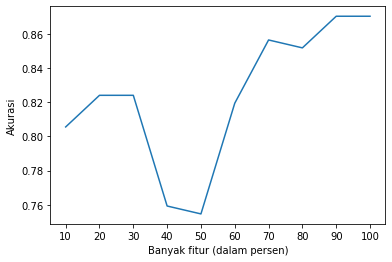

7369 ---
Klasifikasi dengan 737 fitur / 10.0 %
              precision    recall  f1-score   support

           0       0.30      1.00      0.46        18
           1       0.82      0.78      0.80        18
           2       1.00      0.89      0.94        18
           3       0.71      0.94      0.81        18
           4       0.85      0.61      0.71        18
           5       0.94      0.89      0.91        18
           6       1.00      0.56      0.71        18
           7       0.92      0.67      0.77        18
           8       1.00      0.39      0.56        18
           9       1.00      0.94      0.97        18
          10       0.93      0.78      0.85        18
          11       0.86      0.33      0.48        18

    accuracy                           0.73       216
   macro avg       0.86      0.73      0.75       216
weighted avg       0.86      0.73      0.75       216

Akurasi= 0.7314814814814815
----------------------------------------------------------

Klasifikasi dengan 7369 fitur / 100.0 %
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.88      0.83      0.86        18
           2       0.94      0.89      0.91        18
           3       0.69      1.00      0.82        18
           4       0.75      1.00      0.86        18
           5       0.89      0.89      0.89        18
           6       1.00      1.00      1.00        18
           7       0.90      1.00      0.95        18
           8       1.00      0.61      0.76        18
           9       0.95      1.00      0.97        18
          10       1.00      0.78      0.88        18
          11       0.93      0.78      0.85        18

    accuracy                           0.89       216
   macro avg       0.91      0.89      0.89       216
weighted avg       0.91      0.89      0.89       216

Akurasi= 0.8935185185185185
----------------------------------------------------------------


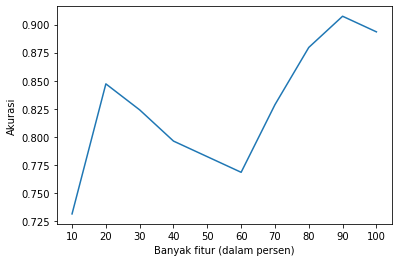

In [10]:
dff = [df,dfNo]
for i in range(2):
    fclas(dff[i])

In [19]:
print(df.text.loc[124])
print("-")
print(dfNo.text.loc[124])

jadi hingga mulut tak tutup nyata benar ada kasus alami orang wanita tiongkok wanita tahu sedang ada buah kereta arah buah stasiun selatan guangzhou tiongkok bahak bahak hingga mulut nganga tak tutup lansir senin orang dokter betul ada kereta segera panggil usai periksa perempuan alami lepas rahang tengkorak sedang istirahat dengar umum ada dokter gegas temu tumpang tidak bicara tutup mulut kata kata dokter nama luo wensheng sebut media tempat guancha awal ira alami stroke kata wensheng kutip wensheng sempat periksa tekan darah pasien coba periksa kondisi wanita tahu rahang alami dislokasi dokter tugas wensheng of liwan hospital guangzhou medical university awal ragu coba laku prosedur darurat pada pasien rasa bukan ahli dia tetap coba tutup mulut pasien pasien sangat gugup otot otot wajah sangat tegang gagal upaya pertama kata wensheng dia sempat minta pasien pergi rumah sakit nanti kereta henti tugas kereta kata baru tiba hingga satu jam tumpang sangat gelisah ingin rahang segera kem